In [14]:
include("../src/variationaltimedisc.jl")
using GradientRobustMultiPhysics
using ExtendableGrids
using Printf
using ExtendableSparse
using DelimitedFiles
using SimplexGridFactory
using Triangulate

In [15]:
function get_flow_data(ν, example)
    ## note that dependencies "XT" marks the function to be x- and t-dependent
    ## that causes the solver to automatically reassemble associated operators in each time step
    u = DataFunction((result, x, t) -> (
        # result[1] = 3*t^4*(x[1]+x[2]); 
        # result[2] = -3*t^4*(x[1]+x[2]);
        result[1] = (1+t)*cos(x[2]);
        result[2] = (1+t)*sin(x[1]);
        ), [2,2]; name = "u", dependencies = "XT", bonus_quadorder = 5)
    p = DataFunction((result, x) -> (
        result[1] = sin(x[1]+x[2]) - 2*sin(1)+sin(2)
        ), [1,2]; name = "p", dependencies = "X", bonus_quadorder = 5)
  
    ############## common code for all examples #####
    dt_u = eval_dt(u)
    Δu = eval_Δ(u)
    ∇u = eval_∇(u)
    ∇p = eval_∇(p)
    f = DataFunction((result, x, t) -> (
          result .= dt_u(x,t) .- ν*Δu(x,t) .+ view(∇p(x,t),:); # .+∇u(x,t)*u(x,t)
        ), [2,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)  
    return u, p, f
  end

get_flow_data (generic function with 1 method)

In [16]:
function ConvQuad(n=10, α=1.0)
    ω = zeros(n+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:n+1 
        ω[j] = (j-2-α)/(j-1) * ω[j-1]
    end
    ω_s = zeros(n+1)
    ω_s[1] = ω[1]
    for j=2:n 
        ω_s = ω_s[j-1] + ω[j]
    end
    return ω, ω_s
end

ConvQuad (generic function with 3 methods)

In [22]:
function run_main(;scheme = 1, ν = 1, nlevels=3, fe_type = 1, rec_type = 1, T0 = 0, Tf=1, α=1.0,
    nsteps=10, reconstruct = false, example = 1, verbosity = 0)

    # set log level
  set_verbosity(verbosity)
  ## initial grid 
  #xgrid = grid_unitsquare(Triangle2D)
  # refine the grid 
  #xgrid = uniform_refine(xgrid, nlevels)  
  xgrid = simplexgrid(Triangulate;
            points=[0 0 ; 0 1 ; 1 1 ; 1 0]',
            bfaces=[1 2 ; 2 3 ; 3 4 ; 4 1 ]',
            bfaceregions=[1, 2, 3, 4],
            regionpoints=[0.5 0.5;]',
            regionnumbers=[1],
            regionvolumes=[4.0^(-nlevels-1)/2])
  println(xgrid)

  ## choose one of these (inf-sup stable) finite element type pairs
  FETypes = [H1P2{2,2}, H1P1{1}] # Taylor-Hood elements
  
  u, p, f= get_flow_data(ν, example)
  ω, ω_s = ConvQuad(nsteps, α)
  @show ω
  @show ω_s

#   # generate FE spaces
#   FES = [FESpace{FETypes[1]}(xgrid), FESpace{FETypes[2]}(xgrid)]
#   # solution vector
#   Solution = FEVector(["u_h", "p_h"], FES)
#   res = FEVector(["u_h", "p_h"], FES)
#   Solnm1 = FEVector(FES)
#   interpolate!(Solnm1[1], u; time = 0.0)
#   Solnm2 = FEVector(FES)
#   interpolate!(Solnm2[1], u; time = 1e-15)

#   ndofu = FES[1].ndofs
#   ndofp = FES[2].ndofs
#   # n_unknown = length(Solution.entries)  
#   GradientRobustMultiPhysics.interpolate!(Solution[1], u; time = 0.)

#   # mass matrix 
#   M = FEMatrix{Float64}(FES)
#   assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
#   # velocity pressure matrices
#   A = FEMatrix{Float64}(FES)
#   assemble_operator!(A[1,1], LaplaceOperator(ν))
#   assemble_operator!(A[1,2], LagrangeMultiplier(Divergence); At = A[2,1]) 

#   rhs = FEVector{Float64}(FES)
#   assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)

#   # GradientRobustMultiPhysics.full_assemble!(ANL[1,1], rhsNL[1], DCO, [Solution[1], Solution[1]])
#   dt = Array{BoundaryData,1}(undef,0)
#   push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
#   dofs = boundarydata!(Solution[1], dt; time = 0.0)
  
#   t0 = T0
#   if scheme == 1
#       tau = (Tf - T0)/nsteps
#   end
#   if scheme == 2
#       tau = (Tf - T0)/nsteps
#   end

#   V1 = zeros(Float64, ndofu, 1)

#   SystemMatrix = FEMatrix(FES)
#   # @show SystemMatrix
#   SystemRHS = FEVector(FES)
#   SystemSol = FEVector(FES)
  
#   step = one(Int)

#   l2max = -one(Float64)
#   first_step  = true
# #------------------------------------------------------------------------------
#   nts = 1
#   oldL2 = zero(Float64); oldh1 = zero(Float64)
#   eL2 = zero(Float64); eh1 = zero(Float64)
#   l2 = zero(Float64); h1 = zero(Float64)
#   l2p = zero(Float64)
#   tol = 1e-12
#   max_iter = 10
#   niter = zero(Int64)
  # while t0 <= Tf-1e-10
  #   t0 = t0 + tau    
  #   fill!(rhs.entries, 0)
  #   assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
  #   V1[:, 1] = rhs[1][:]

  #   fill!(SystemRHS.entries, 0)
  #   fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
  #   fill!(A[1,1], 0)
  #   if nts == 1
  #     if scheme == 2
  #       @info ("First step is with BDF1")
  #     end
  #     addblock!(SystemRHS[1], M.entries*Solution[1].entries ; factor= 1.0/tau)
  #     addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )

  #     #system matrix
  #     assemble_operator!(A[1, 1], LaplaceOperator(ν); time=t0 )
  #     addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/tau)      
  #   else
  #     # system rhs
  #     addblock!(SystemRHS[1], M.entries*Solnm1[1].entries; factor=  2.0/tau)
  #     addblock!(SystemRHS[1], M.entries*Solnm2[1].entries; factor= -0.5/tau)
  #     addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
  #     # system matrix 
  #     assemble_operator!(A[1, 1], LaplaceOperator(ν); time=t0 )
  #     addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.5/tau)
  #   end
  #   addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
  #   addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
  #   addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)

  #   niter = 0
  #   residual = 1e60
  #   flush!(SystemMatrix.entries)
  #   while residual >= tol && niter < max_iter      
  #     dofs = boundarydata!(Solution[1], dt; time = t0)
  #     for dof in dofs
  #       SystemRHS[1][dof] = 1e60 * Solution[1][dof]
  #       SystemMatrix[1,1][dof,dof] = 1e60
  #     end
  #     # ANL[1,1][1,1] = 1e60
  #     SystemMatrix[2,2][1,1] = 1e60
  #     # residual computation
  #     GradientRobustMultiPhysics.mul!(res.entries,SystemMatrix.entries,Solution.entries)
  #     res.entries .-= SystemRHS.entries
      
  #     for dof in dofs 
  #       res[1][dof] = 0
  #     end
  #     residual = norm(res.entries)
  #     # @show sqrt(residual)
  #     flush!(SystemMatrix.entries)
  #     # solve the system 
  #     Solution.entries[:] = SystemMatrix.entries \ SystemRHS.entries
  #     niter = max_iter
  #   end
        
  #   L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
  #   l2 = evaluate(L2Error_u, Solution[1])

  #   h1_err = L2ErrorIntegrator(∇(u), Gradient; time= t0)
  #   h1 = evaluate(h1_err, Solution[1])

  #   pmean = ItemIntegrator([Identity])
  #   mv = evaluate(pmean, Solution[2])
  #   for j = 1 : ndofp
  #     Solution[2][j] -= mv
  #   end
  #   L2Error_p = L2ErrorIntegrator(p, Identity; time= t0)
  #   l2p = evaluate(L2Error_p, Solution[2])

  #   if scheme == 2
  #     nts = nts + 1
  #     for j=1:ndofu + ndofp
  #       Solnm2[1][j] = Solnm1[1][j]
  #       Solnm1[1][j] = Solution[1][j]
  #     end
  #   end
  #   # println(t0, "\t", sqrt(l2), '\t', sqrt(h1))
  # end
  # @show sqrt(l2), sqrt(h1), sqrt(l2p)
  # return sqrt(l2), sqrt(h1), sqrt(l2p)
  println("done")
end

run_main (generic function with 1 method)

In [21]:
ns = [4 8 16 32 64]
ns = [1 2 3 4 5]
eL2u=[]; eH1u=[]; eL2p=[];  
for n in ns
  el2u, eh1u, el2p = run_main(scheme = 2, ν = 1, nlevels=n, fe_type = 1, rec_type = 1, T0 = 0, Tf=1, 
  nsteps=5, reconstruct = false, example = 1, verbosity = 0)
  push!(eL2u, el2u)
  push!(eH1u, eh1u)
  push!(eL2p, el2p)
end

ExtendableGrid{Float64, Int32};
dim: 2 nodes: 26 cells: 34 bfaces: 16




LoadError: BoundsError: attempt to access Float64 at index [2]

L2: Any[0.00022265188871697383, 1.8672787024909263e-5, 1.937934281713542e-6, 2.463615320156575e-7, 3.1892959244990876e-8]
H1u: Any[0.005334612282397041, 0.0010110832648429885, 0.00022530474597944657, 5.675144142375829e-5, 1.4427800825678282e-5]
L2p: Any[0.00545238168261242, 0.000905218287046943, 0.00018024787527720239, 4.672178789290355e-5, 1.1839086473584525e-5]


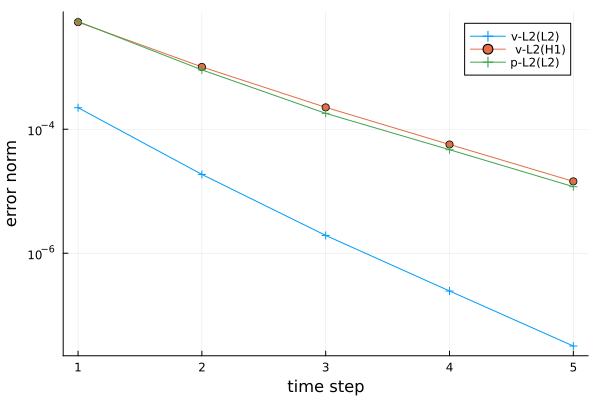

In [9]:
using Plots
println("L2: ", eL2u)
println("H1u: ", eH1u)
println("L2p: ", eL2p)
taus = [ 1,2,3,4,5]
plot(taus,[eL2u eH1u eL2p],
    yaxis=:log10,
    label=["v-L2(L2)" " v-L2(H1)" "p-L2(L2)" ],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

In [10]:
for i=1:length(eL2u)
    if i==1        
        println(i, " ", eL2u[i], " ----------------- ", eH1u[i], " ----------------- ", eL2p[i])
    else
        println(i, " ", eL2u[i], " ", log2(eL2u[i-1]/eL2u[i]), 
        " ", eH1u[i], " ", log2(eH1u[i-1]/eH1u[i]),
        " ", eL2p[i], " ", log2(eL2p[i-1]/eL2p[i]))
    end
end

1 0.00022265188871697383 ----------------- 0.005334612282397041 ----------------- 0.00545238168261242
2 1.8672787024909263e-5 3.575780670368638 0.0010110832648429885 2.399481609212113 0.000905218287046943 2.5905489234752457
3 1.937934281713542e-6 3.268345721759403 0.00022530474597944657 2.165952202157193 0.00018024787527720239 2.328283476558278
4 2.463615320156575e-7 2.975670737692342 5.675144142375829e-5 1.9891487630103146 4.672178789290355e-5 1.947814865693744
5 3.1892959244990876e-8 2.949467132862943 1.4427800825678282e-5 1.9758056236077057 1.1839086473584525e-5 1.9805377184142556
